In [60]:
import os, sys
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import investpy
from glob import glob
from sklearn.metrics import confusion_matrix
from tradercompany import Company
from tradercompany.aggregations import top_average

---
### 1. Prepare Data

#### download

In [2]:
ticker_info = {
    
    "investing": {
        "Bond": [
            'United States 10-Year',
            'United States 1-Year'
        ],
        "Currency": [
            "US Dollar Index"
        ],
    },
    
    "yfinance": {
        "Commodity": [
            "GC=F",
            "SI=F",
            "CL=F",
            "NG=F"
        ],
        "Equity": [
            "^GDAXI",
            "^N225",
            "^FTSE",
            "^GSPC",
            "^VIX"
        ],
        "Forex": [
            "AUDUSD=X",
            "EURUSD=X",
            "GBPUSD=X",
            "USDJPY=X",
            "USDCHF=X",
            "USDTRY=X"
        ]
    }
}

In [3]:
def get_investcom(symbol):
    search_res = investpy.search(text=symbol)
    search_res = [r for r in search_res if r.name == symbol][0]
    df = search_res.retrieve_historical_data(
        from_date='01/01/1950',
        to_date='01/04/2021'
    ).drop_duplicates()
    return df

def get_bulk_yfincane(symbol_list):
    df = yf.download(" ".join(symbol_list), interval="1d", period="max", end="2021-04-01")
    df = df.swaplevel(0, 1, axis=1)
    tickers = df.columns.get_level_values(0).unique()
    res = {}
    for sym in tickers:
        res[sym] = df.loc[:, sym]
    return res

In [4]:
# pull sample data
os.makedirs("data/", exist_ok=True)

# investing.com
tickers = np.concatenate(list(ticker_info["investing"].values()))
for sym in tickers:
    print(sym)
    df = get_investcom(sym)
    df.to_csv(f'''data/{sym.replace(" ", "_")}.csv''')

# yahoo
tickers = np.concatenate(list(ticker_info["yfinance"].values()))
df_dict = get_bulk_yfincane(tickers)
for sym, df in df_dict.items():
    df.to_csv(f'''data/{sym}.csv''')

United States 10-Year
United States 1-Year
US Dollar Index
[*********************100%***********************]  15 of 15 completed


#### preprocess

In [3]:
# load data
files = glob("data/*")
data = {}
for file in files:
    ticker = file.split("/")[-1].replace(".csv", "").replace("=X", "").replace("=F","").replace("^", "").replace("-", "")
    data[ticker] = pd.read_csv(file, parse_dates=["Date"], index_col=["Date"])

In [4]:
# use only close price
closes = pd.concat([df.Close.to_frame(ticker).copy() for ticker, df in data.items()], axis=1)
closes = closes.resample("1d").first()
closes.head(1).append(closes.tail(1))

,N225,EURUSD,USDJPY,SI,AUDUSD,United_States_1Year,United_States_10Year,VIX,FTSE,GSPC,USDCHF,GC,CL,NG,USDTRY,GBPUSD,GDAXI,US_Dollar_Index
Date,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,NaN,NaN,NaN,NaN,NaN,0.063,1.6735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.93


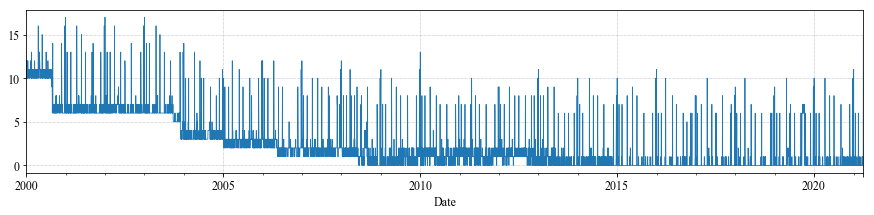

In [5]:
# number of NaN  -> use 2009.01.01:
closes.isna().loc[closes.index.weekday<5].loc["2000.01.01":].sum(axis=1).plot(figsize=(15,3));

In [6]:
closes = closes.loc[closes.index.weekday<5].loc["2009.01.01":].fillna(method="ffill").dropna()

---
### Train

In [7]:
target = "USDJPY"
features, labels = closes.pct_change(), closes[target].pct_change(-1).mul(-1)
_ = features.join(labels.to_frame("label")).dropna()
features, labels = _.iloc[:, :-1], _.iloc[:, -1]

In [61]:
model = Company(
    n_traders=100,
    n_features=features.shape[1], 
    max_terms=10,
    max_lag=9,
    educate_pct=50,
    eval_lookback=100,
    aggregate=top_average
)

In [62]:
# reshape feature
X, y = model.conv_feature(features.values, labels.values)

In [63]:
X.shape

(3182, 10, 18)

In [64]:
# split 
n_train = 2000
x_train = X[:n_train]
y_train = y[:n_train]
x_test  = X[n_train:]
y_test  = y[n_train:]
n_warm  = 100

In [65]:
pnl = lambda x, y: pd.Series(np.sign(x) * y).cumsum()

In [66]:
pred = model.dynamic_predict(x_train, y_train, t_warm=100, n_pct=50)

100%|██████████| 1900/1900 [02:06<00:00, 15.07it/s]


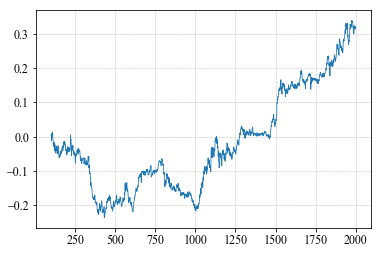

In [67]:
pnl(pred, y_train).plot()

In [70]:
pred2 = model.dynamic_predict(x_test, y_test, t_warm=100, n_pct=50)

100%|██████████| 1082/1082 [01:12<00:00, 14.86it/s]


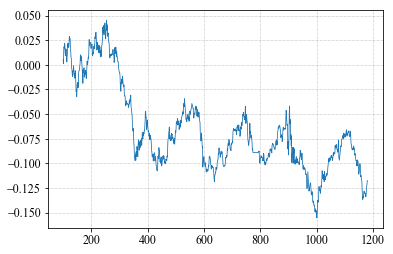

In [71]:
pnl(pred2, y_test).plot()